## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation


Importing plotly failed. Interactive plots will not work.


In [2]:
df_original = pd.read_csv('FB.csv')
df=df_original[['Date','Close']]
df['y'] =df.Close
df['ds']=df.Date
df['ds']=pd.to_datetime(df['ds'])
df=df.drop(['Date','Close'],axis=1)
df.head()

,y,ds
0,145.470001,2017-04-24
1,146.490005,2017-04-25
2,146.559998,2017-04-26
3,147.699997,2017-04-27
4,150.250000,2017-04-28


<AxesSubplot:xlabel='ds'>

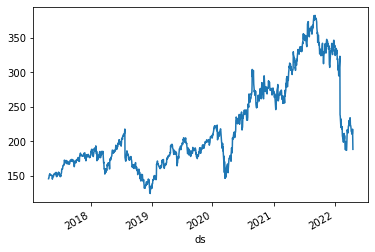

In [3]:
test=df.copy()
test.index=df.ds
test.y.plot()

## Train test split

In [4]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [5]:
len(test)

252

In [6]:
from sklearn import metrics
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
def calculate_metrics(y_test, y_pred,y_train):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred,symmetric=False)
    smape =mean_absolute_percentage_error(y_test, y_pred, symmetric=True)
    print("Results of sklearn.metrics:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("MAPE:", mape)
    print("sMAPE:", smape)
    mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)    
    print('MASE:',mase)

## Build Prophet Model with train only

Initial log joint probability = -9.08466
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2419.83   0.000516579       534.394      0.3119           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2428.65    0.00103587       706.104           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2433.71    2.3912e-05        551.09      0.8998      0.8998      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2434.07   6.26159e-06       547.462           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       2434.37   0.000599809       965.589   9.186e-07       0.001      556  LS failed, Hessian reset 
     499       2434.69   1.33353e-05    

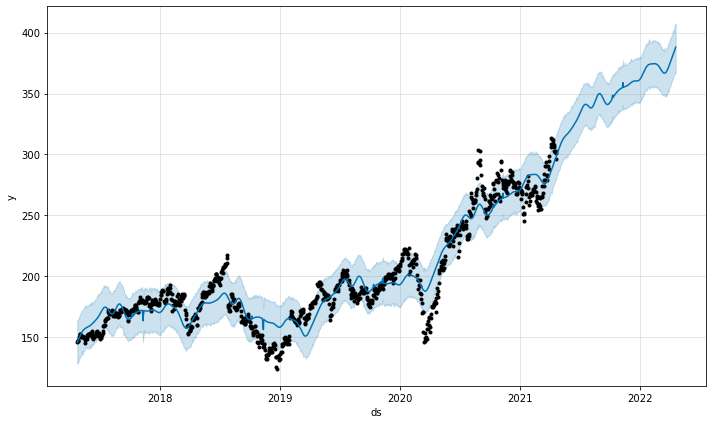

In [12]:
model_1 = Prophet(changepoint_prior_scale=0.01,n_changepoints=100, seasonality_prior_scale=0.1,
                weekly_seasonality=False, seasonality_mode='additive',
                daily_seasonality=True)
model_1.add_country_holidays(country_name='US')

model_1.fit(train)

future_data_weekday=df.drop(['y'],axis=1)

forecast_data_1 = model.predict(future_data_weekday)
pred_y_1=forecast_data_1['yhat'][len(train):]
calculate_metrics(test.y,pred_y_1,train.y)

p = model_1.plot(forecast_data_1)

<AxesSubplot:title={'center':'Actual vs Forecast for Prophet Model (additive seasonality, US holiday) '}, xlabel='ds'>

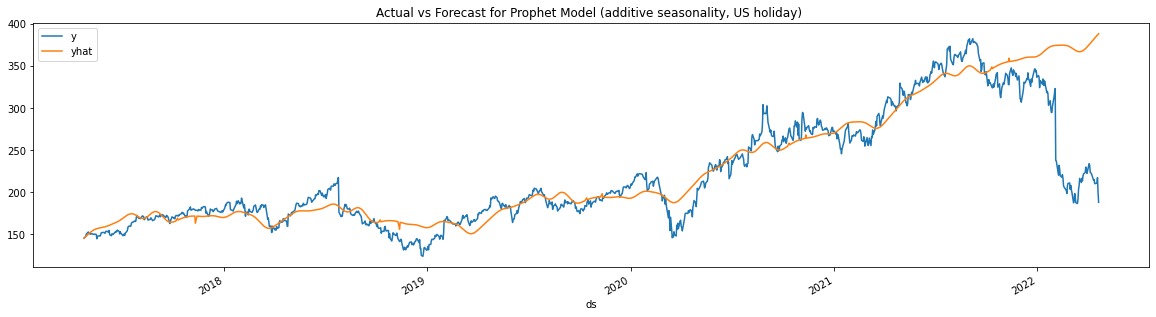

In [18]:
ax = (df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast_data_1.plot(x='ds',y='yhat',figsize=(20,5),
                     title='Actual vs Forecast for Prophet Model (additive seasonality, US holiday) ', ax=ax)

## Adding holiday + dff as regressor

In [19]:
holiday_meta = pd.read_csv('event_dates.csv')
holiday_meta.rename(columns={'events':'holiday','dates':'ds'}, inplace=True)
holiday_meta['ds']=pd.to_datetime(holiday_meta['ds'])
holiday_meta=holiday_meta[1:]
holiday_meta.head()
# Python
events = pd.DataFrame({
  'holiday': 'events',
  'ds':holiday_meta.ds,
  'lower_window': 0,
  'upper_window': 1,
})
holidays = events
holidays.head(2)

,holiday,ds,lower_window,upper_window
1,events,2022-02-02,0,1
2,events,2021-12-01,0,1


### Load Interest Rate dff

In [20]:
dff = pd.read_csv('DFF.csv')
dff.rename(columns={'DFF':'dff','DATE':'ds'}, inplace=True)
dff['ds']=pd.to_datetime(dff['ds'])
dff_cleaned=dff.copy()
train = dff_cleaned.merge(train, on='ds',how='right')
print(train.head(2))
test = dff_cleaned.merge(test, on='ds',how='right')
print(test.head(2))
df=dff_cleaned.merge(df, on='ds',how='right')
print(df.head(2))

          ds   dff           y
0 2017-04-24  0.91  145.470001
1 2017-04-25  0.91  146.490005
          ds   dff           y
0 2021-04-23  0.07  301.130005
1 2021-04-26  0.07  303.040009
          ds   dff           y
0 2017-04-24  0.91  145.470001
1 2017-04-25  0.91  146.490005


### tarin model

In [23]:
model_2 = Prophet(changepoint_prior_scale=0.01,n_changepoints=100, seasonality_prior_scale=0.1,
                weekly_seasonality=False, seasonality_mode='additive',
                daily_seasonality=True,holidays=holidays )
model_2.add_country_holidays(country_name='US')
model_2.add_regressor('dff')
model_2.fit(train)

Initial log joint probability = -9.08466


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2423.5    0.00433108       1046.41      0.6849      0.6849      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2437.43   0.000101744       553.195      0.2969      0.2969      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2441.65   0.000140534        462.86       2.467      0.6913      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          2442   5.57102e-06       451.472      0.5321      0.5321      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2442.59   6.11155e-05       747.082           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     533     

In [24]:
future_data_weekday=df.drop(['y'],axis=1)
forecast_data_2 = model_2.predict(future_data_weekday)
pred_y_2=forecast_data_2['yhat'][len(train):]
calculate_metrics(test.y,pred_y_2,train.y)

Results of sklearn.metrics:
MAE: 53.319836637632605
MSE: 6756.178356360095
MAPE: 0.22301152245683745
sMAPE: 0.17147561843927261
MASE: 18.080428589012854


<AxesSubplot:title={'center':'Actual vs Forecast for Prophet Model (Metaverse events) '}, xlabel='ds'>

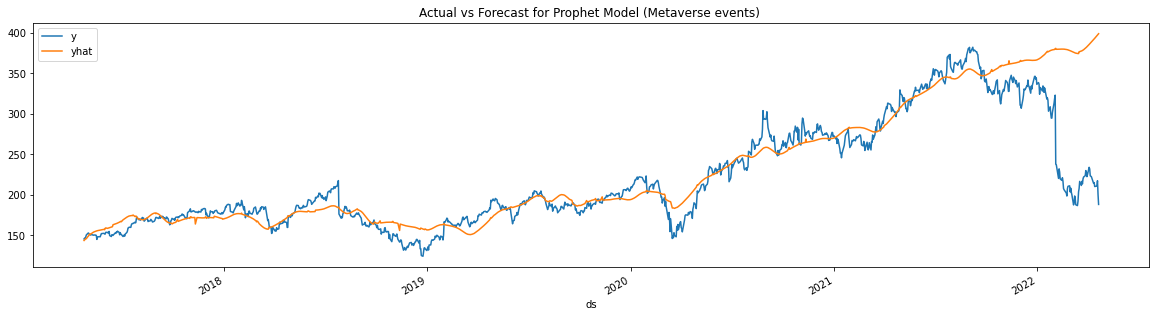

In [26]:
ax = (df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast_data_2.plot(x='ds',y='yhat',figsize=(20,5),
                     title='Actual vs Forecast for Prophet Model (Metaverse events) ', ax=ax)

## Adding holiday + dff + volume as regressor

In [27]:
df_original = pd.read_csv('FB.csv')
df=df_original[['Date','Close','Volume']]
df['y'] =df.Close
df['ds']=df.Date
df['ds']=pd.to_datetime(df['ds'])
df=df.drop(['Date','Close'],axis=1)
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [28]:
dff_cleaned=dff.copy()
train = dff_cleaned.merge(train, on='ds',how='right')
print(train.head(2))
test = dff_cleaned.merge(test, on='ds',how='right')
print(test.head(2))
df=dff_cleaned.merge(df, on='ds',how='right')
print(df.head(2))

          ds   dff    Volume           y
0 2017-04-24  0.91  14407200  145.470001
1 2017-04-25  0.91  17767500  146.490005
          ds   dff    Volume           y
0 2021-04-23  0.07  17536800  301.130005
1 2021-04-26  0.07  16172600  303.040009
          ds   dff    Volume           y
0 2017-04-24  0.91  14407200  145.470001
1 2017-04-25  0.91  17767500  146.490005


In [29]:
model = Prophet(changepoint_prior_scale=0.001,n_changepoints=100, seasonality_prior_scale=0.1,
                weekly_seasonality=False, holidays=holidays )
model.add_regressor('dff')
model.add_regressor('Volume')
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.08466
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.08466             0       1030.58       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -303.491
Iteration  1. Log joint probability =    1128.51. Improved by 1432.
Iteration  2. Log joint probability =    1718.53. Improved by 590.028.
Iteration  3. Log joint probability =    2150.22. Improved by 431.682.
Iteration  4. Log joint probability =    2165.27. Improved by 15.0567.
Iteration  5. Log joint probability =    2198.36. Improved by 33.0851.
Iteration  6. Log joint probability =    2215.67. Improved by 17.3091.
Iteration  7. Log joint probability =    2223.94. Improved by 8.27677.
Iteration  8. Log joint probability =    2232.01. Improved by 8.07178.
Iteration  9. Log joint probability =       2235. Improved by 2.9865.
Iteration 10. Log joint probability =    2237.21. Improved by 2.21036.
Iteration 11. Log joint probability =    2240.57. Improved by 3.36208.
Iteration 12. Log joint probability =    2241.68. Improved by 1.10388.
Iteration 13. Log joint probability =     2243.3. Improved by 1.62573.
Iteration 14. Log joint probability =  

In [30]:
future_data_weekday=df.drop(['y'],axis=1)
forecast_data = model.predict(future_data_weekday)
pred_y=forecast_data['yhat'][len(train):]
calculate_metrics(test.y,pred_y,train.y)

Results of sklearn.metrics:
MAE: 61.53009808146559
MSE: 4090.8932466440433
MAPE: 0.20344081350706336
sMAPE: 0.21056407153777673
MASE: 20.864477736447355


<AxesSubplot:title={'center':'Actual vs Forecast for Prophet Model (Metaverse events, Interest rate) '}, xlabel='ds'>

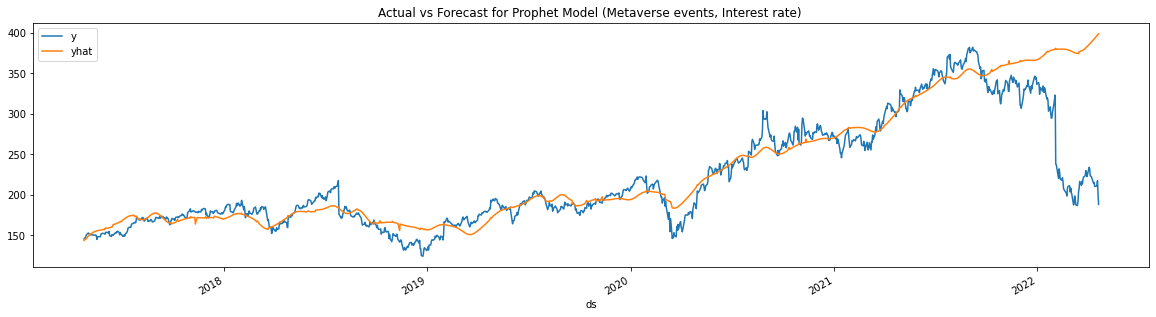

In [32]:
ax = (df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast_data_2.plot(x='ds',y='yhat',figsize=(20,5),
                     title='Actual vs Forecast for Prophet Model (Metaverse events, Interest rate) ', ax=ax)

## Retrain the last model on data before 2022

In [36]:
df_before2022=df_original[['Date','Close','Volume']]
df_before2022['y'] =df_before2022.Close
df_before2022['ds']=df_before2022.Date
df_before2022['ds']=pd.to_datetime(df_before2022['ds'])
df_before2022=df_before2022[df_before2022['ds'] <= '2021-12-31']

df_before2022=df_before2022.drop(['Date','Close'],axis=1)
train_b2022 = df_before2022.iloc[:int(len(df_before2022)*0.8)]
test_b2022 = df_before2022.iloc[int(len(df_before2022)*0.8):]

In [37]:
len(df_before2022)

1183

In [38]:
dff_cleaned=dff.copy()
train_b2022 = dff_cleaned.merge(train_b2022, on='ds',how='right')
print(train_b2022.head(2))
test_b2022 = dff_cleaned.merge(test_b2022, on='ds',how='right')
print(test_b2022.head(2))
df_before2022=dff_cleaned.merge(df_before2022, on='ds',how='right')
print(df_before2022.head(2))

          ds   dff    Volume           y
0 2017-04-24  0.91  14407200  145.470001
1 2017-04-25  0.91  17767500  146.490005
          ds   dff    Volume           y
0 2021-01-26  0.08  19373600  282.049988
1 2021-01-27  0.08  35346200  272.140015
          ds   dff    Volume           y
0 2017-04-24  0.91  14407200  145.470001
1 2017-04-25  0.91  17767500  146.490005


In [41]:
model_b2022 = Prophet(changepoint_prior_scale=0.001,n_changepoints=100, seasonality_prior_scale=0.1,
                weekly_seasonality=False, holidays=holidays, daily_seasonality=True )
model_b2022.add_regressor('dff')
model_b2022.add_regressor('Volume')
model_b2022.fit(train_b2022)


Initial log joint probability = -7.96293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -7.96293             0       972.078       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -235.245
Iteration  1. Log joint probability =    930.591. Improved by 1165.84.
Iteration  2. Log joint probability =    1589.03. Improved by 658.437.
Iteration  3. Log joint probability =     1900.8. Improved by 311.769.
Iteration  4. Log joint probability =    2002.27. Improved by 101.475.
Iteration  5. Log joint probability =    2080.38. Improved by 78.1116.
Iteration  6. Log joint probability =     2133.3. Improved by 52.9129.
Iteration  7. Log joint probability =    2141.06. Improved by 7.76884.
Iteration  8. Log joint probability =    2143.54. Improved by 2.47302.
Iteration  9. Log joint probability =    2147.13. Improved by 3.59576.
Iteration 10. Log joint probability =    2147.21. Improved by 0.07537.
Iteration 11. Log joint probability =    2149.57. Improved by 2.36102.
Iteration 12. Log joint probability =    2149.67. Improved by 0.10114.
Iteration 13. Log joint probability =    2150.89. Improved by 1.22025.
Iteration 14. Log joint probability

In [43]:
future_data_weekday_b2022=df_before2022.drop(['y'],axis=1)
forecast_data_b2022 = model_b2022.predict(future_data_weekday_b2022)
pred_y_b2022=forecast_data_b2022['yhat'][len(train_b2022):]
calculate_metrics(test_b2022.y,pred_y_b2022,train_b2022.y)

Results of sklearn.metrics:
MAE: 62.97806807819707
MSE: 4593.264087501798
MAPE: 0.18818340314890064
sMAPE: 0.2105561516914677
MASE: 22.049508349338197


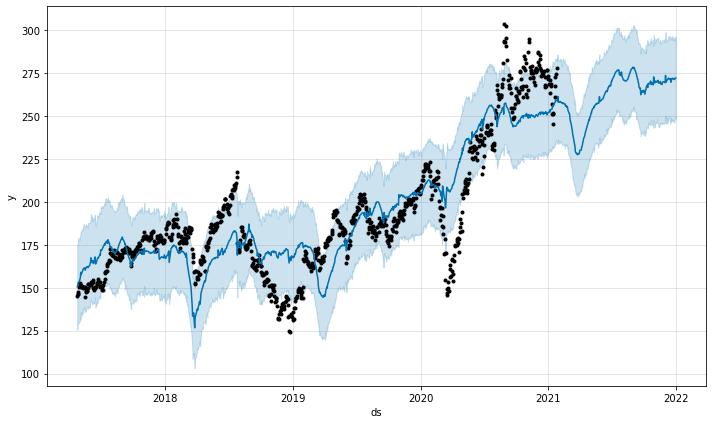

In [47]:
p_b2022 = model_b2022.plot(forecast_data_b2022)

<AxesSubplot:title={'center':'Actual vs Forecast for Prophet Model (Metaverse events, Interest rate) '}, xlabel='ds'>

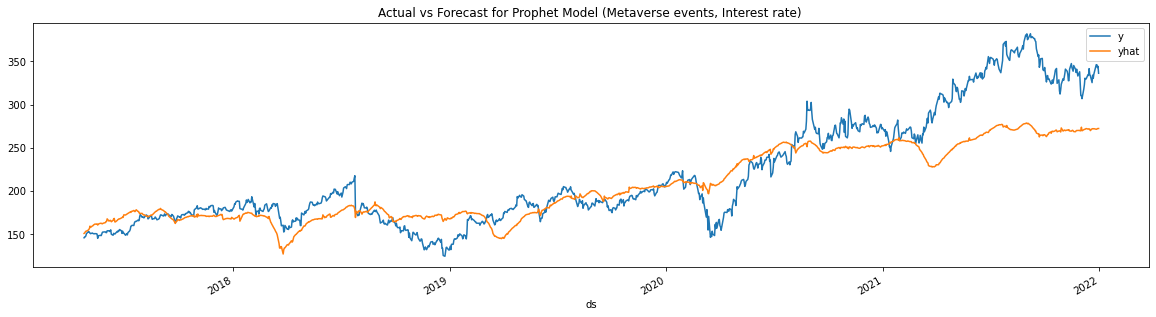

In [46]:
ax = (df_before2022.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast_data_b2022.plot(x='ds',y='yhat',figsize=(20,5),
                     title='Actual vs Forecast for Prophet Model (Metaverse events, Interest rate) ', ax=ax)